In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

from os.path import join

mpl.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Data

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))



ind = int(0.8 * len(index))

# extract only test models
molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))[ind:]

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Fetch Model 

In [4]:
filepath = "../../models/TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)

# Calculated Guesses 

In [5]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import make_matrix_batch, extract_triu_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

p_nn = model.predict(s_test)
#p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, dataset.testing[0])))) # overlap matrix is falsche!
#p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip(p_batch, dataset.testing[0]))))

p_sad = extract_triu_batch(np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules
]), dim)
p_1e = extract_triu_batch(np.array([
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules
]), dim)
p_gwh = extract_triu_batch(np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules
]), dim)

In [6]:
p_test.flatten().shape, p_nn.flatten().shape

((70551,), (70551,))

# Scatter

## Full

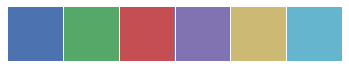

In [7]:
import seaborn as sns
palette = sns.color_palette()
sns.palplot(palette)

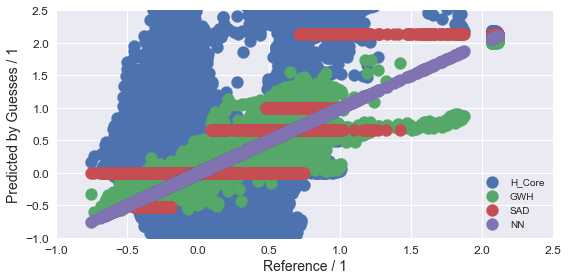

In [8]:
expected = p_test.flatten()

plt.scatter(expected, p_1e.flatten(), label="H_Core")
plt.scatter(expected, p_gwh.flatten(), label="GWH")
plt.scatter(expected, p_sad.flatten(), label="SAD")
plt.scatter(expected, p_nn.flatten(), label="NN")

plt.xlim([-1, 2.5])
plt.ylim([-1, 2.5])

plt.ylabel("Predicted by Guesses / 1")
plt.xlabel("Reference / 1")

plt.legend()
plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/PredictionScatter.png")

plt.show()

## Ausschnitt 

/home/jcartus/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


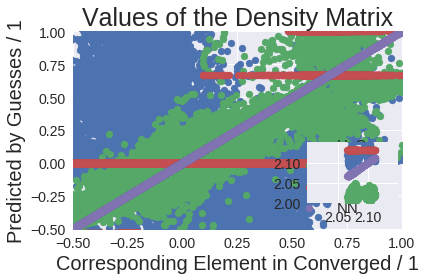

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

expected = p_test.flatten()
upper = 1
lower = -.5


#--- outer ---
fig, ax = plt.subplots()
plt.scatter(expected, p_1e.flatten(), label="H_Core")
plt.scatter(expected, p_gwh.flatten(), label="GWH")
plt.scatter(expected, p_sad.flatten(), label="SAD")
plt.scatter(expected, p_nn.flatten(), label="NN")

plt.title("Values of the Density Matrix", fontsize=25)
plt.ylabel("Predicted by Guesses / 1", fontsize=20)
plt.xlabel("Corresponding Element in Converged / 1", fontsize=20)
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.legend(fontsize=15)
plt.tick_params(labelsize=14)
plt.tight_layout()
#---

#--- insert ---
lower, upper = 2.0, 2.15
#ax_inner = inset_axes(ax, width="20%", height="25%", loc=7)
ax_inner = plt.axes([0.72, 0.28, 0.21, 0.21])
ax_inner.scatter(expected, p_1e.flatten(), label="H_Core")
ax_inner.scatter(expected, p_gwh.flatten(), label="GWH")
ax_inner.scatter(expected, p_sad.flatten(), label="SAD")
ax_inner.scatter(expected, p_nn.flatten(), label="NN")

plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.xticks([2.05, 2.1])
plt.yticks([2.0,2.05, 2.1])
plt.tick_params(labelsize=14)

#plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25
plt.tight_layout()
#---
#plt.savefig("/home/jo/Repos/cc2aiPoster/figures/EthinPredictionScatter.png")
plt.show()

# Weighted Errors 

In [13]:
overlap = s_test.flatten()

In [17]:
def weighted_error(p):
    return np.abs(p.flatten() - expected) * overlap

e_batch = weighted_error(p_nn)
#e_mcw1 = weighted_error(p_mcw1)
#e_mcw5 = weighted_error(p_mcw5)
e_sad = weighted_error(p_sad)
e_1e = weighted_error(p_1e)
e_gwh = weighted_error(p_gwh)

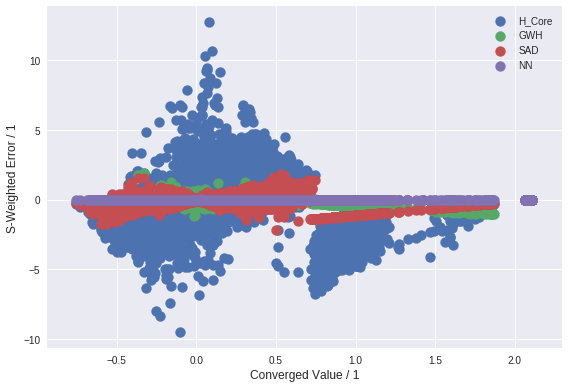

In [25]:
plt.scatter(expected, e_1e, label="H_Core")
plt.scatter(expected, e_gwh, label="GWH")
plt.scatter(expected, e_sad, label="SAD")
plt.scatter(expected, e_batch, label="NN")
#plt.scatter(expected, e_mcw1, label="McW-1")
#plt.scatter(expected, e_mcw5, label="McW-5")


#plt.ylim(ylim)
#plt.xlim(xlim)

#plt.title("Weighted Density Matrix Errors", fontsize=25)
plt.ylabel("S-Weighted Error / 1")
plt.xlabel("Converged Value / 1")
plt.legend()
#plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/OverlapWeightedErrors.png")

plt.show()